In [1]:
import scipy
import numpy as np
import pandas as pd
from learner import learner
from hw2_resources.plotBoundary import *
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
X = np.array([[2,2],[2,3],[0,-1], [-3, -2]])
Y = np.array([1, 1, -1, -1]).reshape((4,1))

svm = learner()
svm.set_data(X,Y)

In [3]:
def data_path(i, type):
    return 'hw2_resources/data/data' + str(i) + '_' + type + '.csv'

def plot_data(i, X, Y, values, ax, title = None, kind = 'kernel'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = max((x_max-x_min)/20., (y_max-y_min)/20.)
    xx, yy = meshgrid(arange(x_min, x_max, h),
                      arange(y_min, y_max, h))
    zz = array([svm.predict(x, kind) for x in c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)

    CS = ax.contour(xx, yy, zz, values, colors = 'black', linewidths = 2)
    CS = ax.contour(xx, yy, zz, (-1, 1), colors = 'black', linestyles = 'dashed', linewidths = 2)
#     ax.clabel(CS, fontsize=9, inline=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)
    ax.set_title(title)
#     ax.axis('tight')

def read_data(path):
    data = pd.read_table(path, sep = ' ', header = None)
    X = np.array(data[[0,1]])
    Y = np.array(data[[2]])
    return((X,Y))

In [4]:
table = pd.DataFrame({'Data Set' : [],
                      'Lambda': [],
                      'Margin': []})


for i in [1, 2, 3, 4]:
    lambdas = [2**j for j in np.arange(-20, 1)]
    X,Y = read_data(data_path(i, 'train'))
    
    svm = learner()
    svm.set_data(X,Y)

    X_val, Y_val = read_data(data_path(i, 'validate'))

    for l in lambdas:
        svm.train_pegasos_linear(l,1)
        training_error = svm.training_error(kind = 'pegasos')
        validation_error = svm.test_error(X_val, Y_val,kind = 'pegasos')

#         fig = plt.figure()
#         ax = fig.add_subplot(1,1,1)
#         plot_data(i, 
#                   X, 
#                   Y, 
#                   (0), 
#                   ax, 
#                   'Train:' + str(training_error) + ' Test: ' + str(validation_error),
#                  kind = 'pegasos')

#         plt.savefig('figs/pegasos_linear_' + str(i) + '_lambda_' + str(l) + '.pdf')
        
        
        add_to_table = pd.DataFrame({'Data Set' : [i],
                                 'Lambda'  : [l],
                                 'Margin': [svm.get_margin()]})
        table = table.append(add_to_table)
        
        

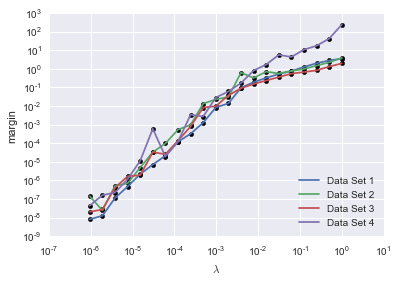

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in set(table['Data Set']):
    ax.plot(table.Lambda[table['Data Set'] == i],table.Margin[table['Data Set'] == i], label = 'Data Set ' + str(int(i)))
    ax.scatter(table.Lambda[table['Data Set'] == i],table.Margin[table['Data Set'] == i], label = int(i), color = 'black')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:4], labels[0:4], loc = 4)
#     plt.legend(loc = 4)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel('margin')

plt.savefig('figs/pegasos_linear_margin.pdf')

In [6]:
# kernels we're using
def gaussian_kernel(x, y, s = 1):
    return scipy.exp(-(np.linalg.norm(x - y))**2 / (s**2))

def linear_kernel(x,y):
    return np.dot(x,y)

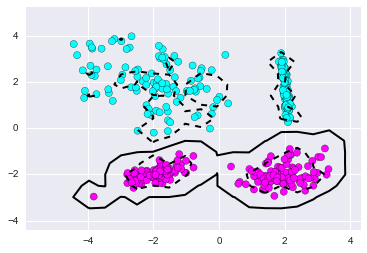

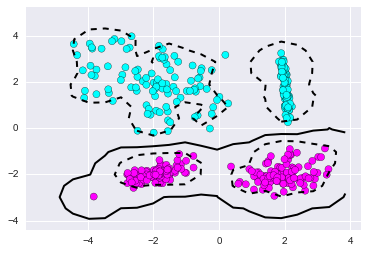

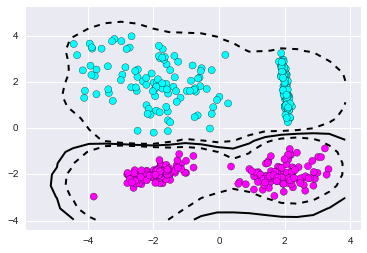

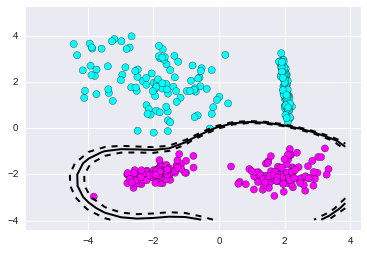

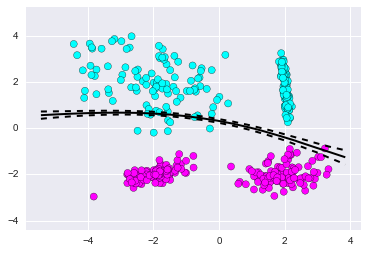

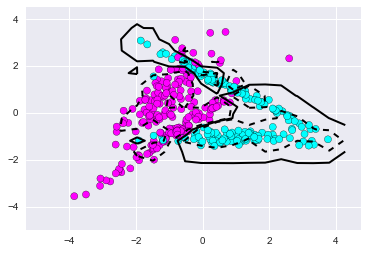

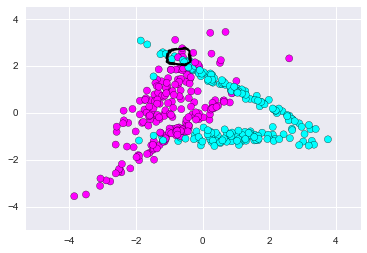

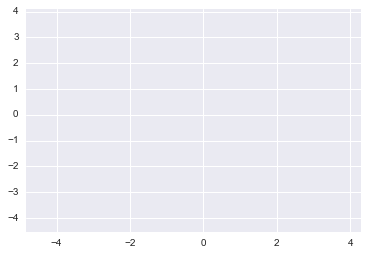

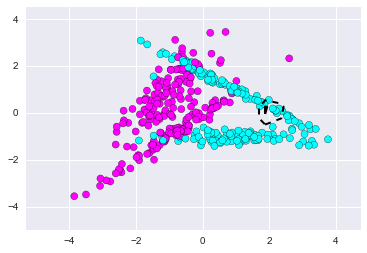

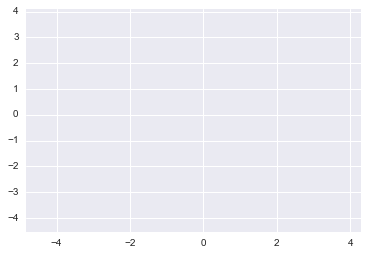

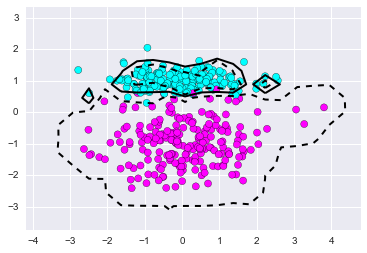

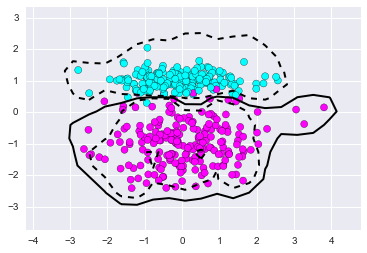

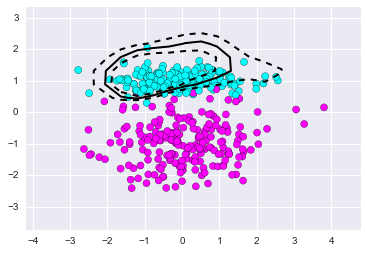

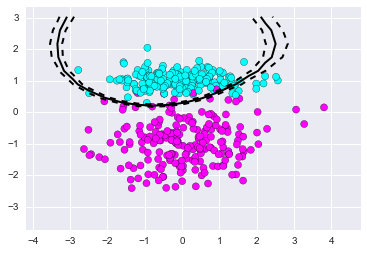

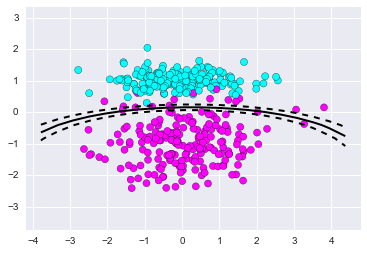

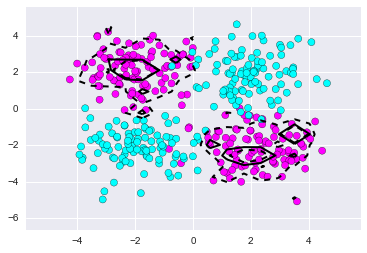

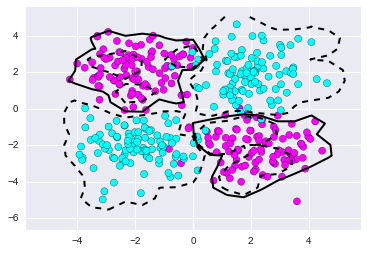

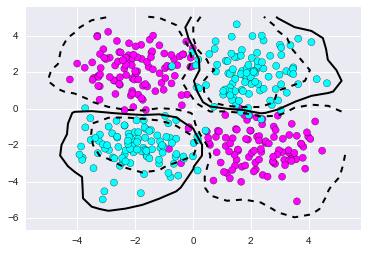

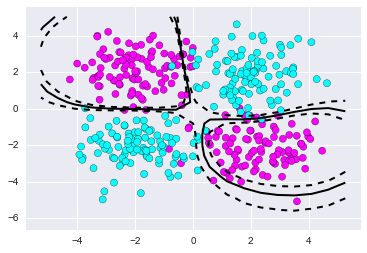

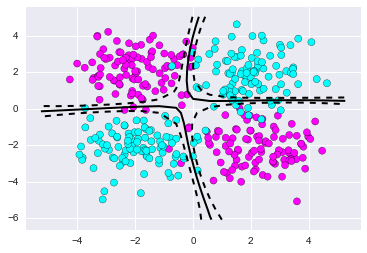

In [9]:
table = pd.DataFrame({'Data Set' : [],
                      'gamma': [],
                      'Support vectors': []})

gamma = 0.02
max_epochs = 100

for i in [1, 2, 3, 4]:

    X,Y = read_data(data_path(i, 'train'))

    svm = learner()
    svm.set_data(X,Y)
    X_val, Y_val = read_data(data_path(i, 'validate'))
    for s in [2**j for j in [-2, -1, 0, 1, 2]]:
        svm.set_kernel_function(lambda x, y: gaussian_kernel(x,y, s = s))
        svm.make_kernel_matrix()
        svm.train_pegasos_kernelized(gamma, max_epochs)

        training_error = svm.training_error('kernel')
        validation_error = svm.test_error(X_val, Y_val, 'kernel')
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        try:
            plot_data(i, 
                  X, 
                  Y, 
                  (0), 
                  ax, 
                  '', 
                  'kernel')
            plt.savefig('figs/pegasos_gaussian_data_' + str(i) + '_s_' + str(s) + '.pdf')
        except ValueError:
            pass

        add_to_table = pd.DataFrame({'Data Set' : [i],
                                     'gamma'  : [s],
                                     'Support vectors': [len(svm.get_supports())]})
        table = table.append(add_to_table)

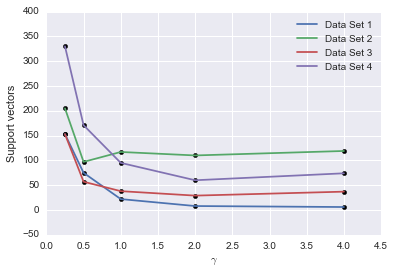

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in set(table['Data Set']):

    ax.plot(table.gamma[table['Data Set'] == i],table['Support vectors'][table['Data Set'] == i], label = 'Data Set ' + str(int(i)))
#     plt.legend()
    ax.scatter(table.gamma[table['Data Set'] == i],table['Support vectors'][table['Data Set'] == i], color = 'black')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:4], labels[0:4])
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel('Support vectors')

plt.savefig('figs/pegasos_gaussian_supports.pdf')

    